In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from scipy.interpolate import interpn
import pynbody

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [30]:
datadir = '/home/pdcg/Documents/post_process_routines/'
simulation = 'Au6_lvl5_c51f15ce/'
s = pynbody.load(datadir+simulation+'snapdir_080/snapshot_080')

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/snapshot/gadgethdf.py:403: UserWarning: Masses are either stored in the header or have another dataset name; assuming the cosmological factor h**-1
  warnings.warn("Masses are either stored in the header or have another dataset name; assuming the cosmological factor %s" % units.h**-1)


In [3]:
# s['eps'] = s['smooth']
# for key in s.families():
#   s[key]['eps'] = s[key]['eps'].min()

In [31]:
h = s.halos()

In [5]:
transform = pynbody.analysis.angmom.faceon(h[0])
main = h[0].subhalos[0]

In [6]:
s.physical_units()

In [7]:
mask_clusters_initial = main.s['InitialNumberOfClusters'] > 0
mask_clusters_final = main.s['NumberOfClusters'] > 0

truncation_mass = main.s['ICMFTruncationMass'][mask_clusters_initial]
cluster_masses = main.s['ClusterMass'][mask_clusters_initial].flatten()
cluster_radius = main.s['ClusterRadius'][mask_clusters_initial].flatten()
init_cluster_masses = main.s['InitialClusterMass'][mask_clusters_initial].flatten()
init_cluster_radius = main.s['InitialClusterRadius'][mask_clusters_initial].flatten()
masslostrelax = main.s['MassLostRelaxation'][mask_clusters_initial].flatten()
masslostshock = main.s['MassLostShocks'][mask_clusters_initial].flatten()

not_empty_clusters = (init_cluster_masses>0)

cluster_masses = cluster_masses[not_empty_clusters]
cluster_radius = cluster_radius[not_empty_clusters]
init_cluster_masses = init_cluster_masses[not_empty_clusters]
init_cluster_radius = init_cluster_radius[not_empty_clusters]
masslostrelax = masslostrelax[not_empty_clusters]
masslostshock = masslostshock[not_empty_clusters]

print('Maximum initial mass {:2.2e} Msun'.format(init_cluster_masses.max()))
print('Maximum present-day mass {:2.2e} Msun'.format(cluster_masses.max()))

Maximum initial mass 8.94e+06 Msun
Maximum present-day mass 4.81e+06 Msun


In [8]:
clusters_birthtime = []
clusters_age = []
for i, nclt in enumerate(main.s['InitialNumberOfClusters'][mask_clusters_initial]):
  clusters_birthtime.append(np.ones(nclt) * main.s['tform'].in_units('Gyr')[mask_clusters_initial][i])
  clusters_age.append(np.ones(nclt) * main.s['age'].in_units('Gyr')[mask_clusters_initial][i])

clusters_birthtime = np.concatenate(clusters_birthtime)
clusters_age = np.concatenate(clusters_age)

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/array/__init__.py:310: RuntimeWarning: invalid value encountered in log
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)


In [9]:
clusters_disruptiontime = main.s['DisruptionTime'][mask_clusters_initial].flatten()
clusters_disruptiontime = clusters_disruptiontime[not_empty_clusters]
clusters_disruptiontime[clusters_disruptiontime == 0] = -2.
disruption_gyr = np.nan_to_num(pynbody.analysis.cosmology.age(s,z = 1./clusters_disruptiontime - 1.), nan=0.)

In [10]:
lifetime_gyr = disruption_gyr - clusters_birthtime
lifetime_gyr[np.logical_not(disruption_gyr>0)] = 16

In [11]:
young_mask = (clusters_age<0.5)
old_mask = (clusters_age>6.)
veryold_mask = (clusters_age>10.)

In [12]:
def density_scatter( x , y, vmin, vmax, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm=colors.LogNorm(vmin=vmin, vmax=vmax),cmap=cm.viridis, **kwargs )

    return ax, h

In [13]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.logspace(np.log10(min_icmf), np.log10(max_icmf), 25)

min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), 25)

min_rh = 1e-2 # in parsecs
max_rh = 2e2 # in parsecs
rharray = np.logspace(np.log10(min_rh), np.log10(max_rh), 25) # in pc

In [14]:
mw_rhdist = np.loadtxt('MW_rh.csv', delimiter=',')
m31_rhdist = np.loadtxt('M31_rh.csv', delimiter=',')
m83_rhdist = np.loadtxt('M83_rh.csv', delimiter=',')

emp_rhyoung = np.loadtxt('emp_young_rh.csv', delimiter=',')
emp_rh6gyr = np.loadtxt('emp_6gyr_rh.csv', delimiter=',')
emp_rh10gyr = np.loadtxt('emp_10gyr_rh.csv', delimiter=',')

In [15]:
lossratio = masslostshock/masslostrelax

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/array/__init__.py:310: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)


Text(0, 0.5, 'Number')

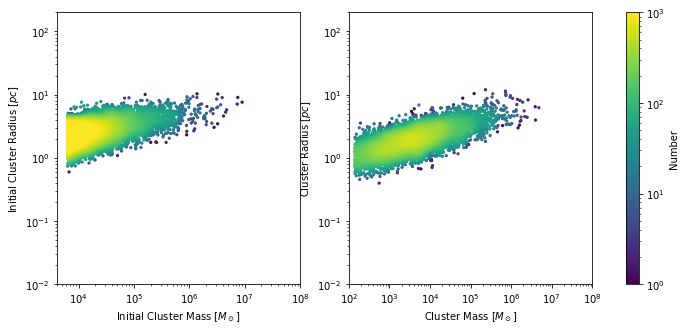

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0], cb = density_scatter(init_cluster_masses, init_cluster_radius*1e3, vmin=1e0, vmax=1e3, ax=ax[0],bins=[marray_icmf, rharray], edgecolors='face', s=5)
ax[0].set(xscale='log', yscale='log', xlim=(4e3, 1e8), ylim=(1e-2, 2e2), xlabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Radius}$ [$pc$]')

ax[1], cb = density_scatter(cluster_masses, cluster_radius*1e3, vmin=1e0, vmax=1e3, ax=ax[1],bins=[marray_gcmf, rharray], edgecolors='face', s=5)
ax[1].set(xscale='log', yscale='log', xlim=(1e2, 1e8), ylim=(1e-2, 2e2), xlabel=r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', ylabel=r'$\rm{Cluster}$ $\rm{Radius}$ [$pc$]')

cbar = fig.colorbar(cb, ax=ax)
cbar.ax.set_ylabel('Number')

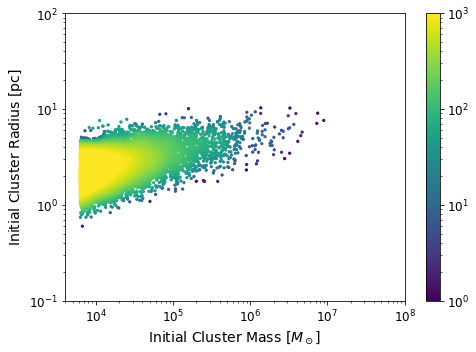

In [17]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax, cb = density_scatter(init_cluster_masses, init_cluster_radius*1e3, vmin=1e0, vmax=1e3, ax=ax,bins=[marray_icmf, rharray], edgecolors='face', s=5)
ax.set(xscale='log', yscale='log', xlim=(4e3, 1e8), ylim=(1e-1, 1e2))
ax.set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=14)
ax.set_ylabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Radius}$ [pc]', fontsize=14)
cbar = fig.colorbar(cb)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('initial_mass_rh.png')

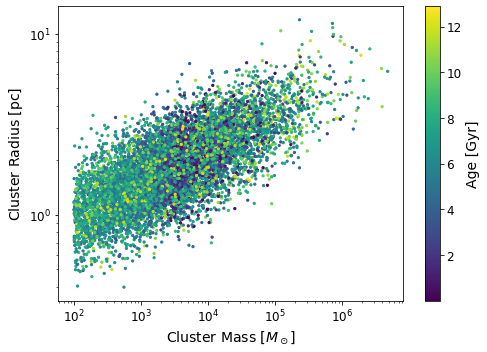

In [18]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
cb = ax.scatter(cluster_masses, cluster_radius*1e3, c=clusters_age, cmap=cm.viridis, s=5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=14)
ax.set_ylabel(r'$\rm{Cluster}$ $\rm{Radius}$ [pc]', fontsize=14)
cbar = fig.colorbar(cb)
cbar.set_label('Age [Gyr]', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('final_mass_radius.png')

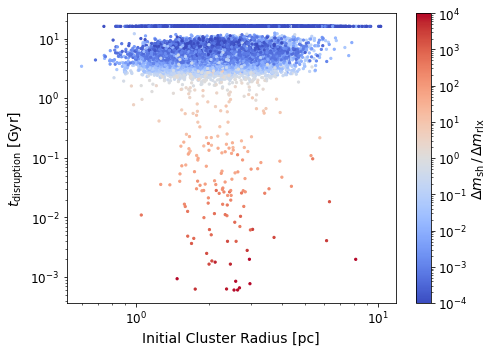

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
cb = ax.scatter(init_cluster_radius*1e3, lifetime_gyr, edgecolors='face', s=5, c=lossratio, cmap=cm.coolwarm, norm=colors.LogNorm(vmin=1e-4, vmax=1e4))
ax.set(xscale='log', yscale='log')#, xlim=(5e-2, 2e2), ylim=(1e-3, 2e1))
ax.set_xlabel('Initial Cluster Radius [pc]', fontsize=14)
ax.set_ylabel(r'$t_{\rm{disruption}}$ [Gyr]', fontsize=14)
cbar = fig.colorbar(cb)
cbar.set_label(r'$\Delta m_\mathrm{sh} \, / \, \Delta m_\mathrm{rlx}$', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('lifetime_radius.png')

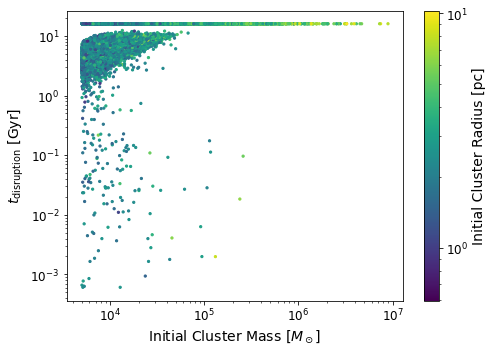

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
cb = ax.scatter(init_cluster_masses, lifetime_gyr, edgecolors='face', s=5, c=init_cluster_radius*1e3, cmap=cm.viridis, norm=colors.LogNorm())
ax.set(xscale='log', yscale='log')#, xlim=(4e3, 1e8), ylim=(1e-3, 2e1))
ax.set_xlabel(r'Initial Cluster Mass [$M_\odot$]', fontsize=14)
ax.set_ylabel(r'$t_{\rm{disruption}}$ [Gyr]', fontsize=14)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label('Initial Cluster Radius [pc]', fontsize=14)
plt.tick_params(labelsize=12)
fig.axes[1].tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('initial_mass_lifetime.png')

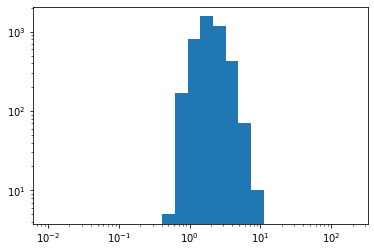

In [21]:
plt.hist(cluster_radius*1e3, bins=rharray)
plt.xscale('log')
plt.yscale('log')

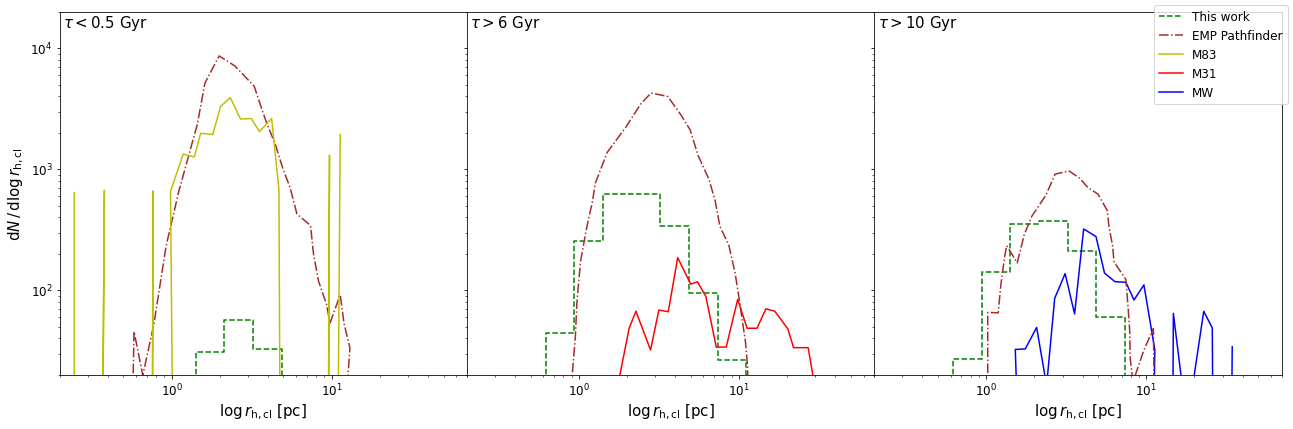

In [22]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18,6))

N, _ = np.histogram(cluster_radius[young_mask]*1e3, bins=rharray)
ax[0].step(rharray[:-1], N*(rharray[1:] - rharray[:-1]), where='post', c='g', linestyle='dashed', label='This work')
ax[0].plot(emp_rhyoung[:,0], emp_rhyoung[:,1], linestyle='dashdot', c='brown', label='EMP Pathfinder')
ax[0].plot(m83_rhdist[:,0], m83_rhdist[:,1], c='y', label='M83')
ax[0].text(2.1e-1,1.5e4,r'$\tau < 0.5$ Gyr', fontsize=15)
ax[0].set(xlim=(2e-1,7e1), xscale='log')
ax[0].set_xlabel(r'$\log r_{\mathrm{h,cl}}$ [pc]', fontsize=15)
ax[0].set(ylim=(2e1,2e4), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log r_{\mathrm{h,cl}}$', fontsize=15)
ax[0].tick_params(labelsize=12)

N, _ = np.histogram(cluster_radius[old_mask]*1e3, bins=rharray)
ax[1].step(rharray[:-1], N*(rharray[1:] - rharray[:-1]), where='post', c='g', linestyle='dashed')
ax[1].plot(m31_rhdist[:,0], m31_rhdist[:,1], c='r', label='M31')
ax[1].plot(emp_rh6gyr[:,0], emp_rh6gyr[:,1], linestyle='dashdot', c='brown')
ax[1].text(2.1e-1,1.5e4,r'$\tau > 6$ Gyr', fontsize=15)
ax[1].set(xlim=(2e-1,7e1), xscale='log')
ax[1].set_xlabel(r'$\log r_{\mathrm{h,cl}}$ [pc]', fontsize=15)
ax[1].tick_params(labelsize=12)

N, _ = np.histogram(cluster_radius[veryold_mask]*1e3, bins=rharray)
ax[2].step(rharray[:-1], N*(rharray[1:] - rharray[:-1]), where='post', c='g', linestyle='dashed')
ax[2].plot(mw_rhdist[:,0], mw_rhdist[:,1], c='b', label='MW')
ax[2].plot(emp_rh10gyr[:,0], emp_rh10gyr[:,1], linestyle='dashdot', c='brown')
ax[2].text(2.1e-1,1.5e4,r'$\tau > 10$ Gyr', fontsize=15)
ax[2].set(xlim=(2e-1,7e1), xscale='log')
ax[2].set_xlabel(r'$\log r_{\mathrm{h,cl}}$ [pc]', fontsize=15)
ax[2].tick_params(labelsize=12)

fig.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(wspace=0)
# plt.savefig('rh_distribution.png')

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/kdtree/__init__.py:352: RuntimeWarning: 

The particles span a region larger than the specified boxsize; disabling periodicity.

For more information about this warning, see the module documentation for KDTree, 
https://pynbody.readthedocs.io/latest/reference/_autosummary/pynbody.kdtree.KDTree.html
  smx = kdmain.nn_start(self.kdtree, int(nn), self.boxsize)


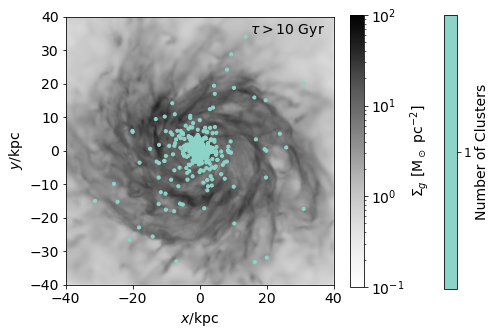

In [21]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
pynbody.plot.sph.image(h[0].g, qty='rho', units='Msol pc^-2', width=80, cmap=cm.Greys, log=True, vmin=1e-1, vmax=1e2, axes=ax, show_cbar=True, weight=False, colorbar_label=r'$\Sigma_g$ [M$_\odot$ pc$^{-2}$]')
mask_mainhalo = (main.s['NumberOfClusters'] > 0) * (main.s['age'].in_units('Gyr') > 10) * (np.abs(main.s['z'])<2)

# Create a discrete colormap with N levels
n_levels = main.s['NumberOfClusters'][mask_mainhalo].max()
discrete_cmap = cm.get_cmap('Set3', n_levels)

cb = ax.scatter(main.s[mask_mainhalo]['x'], main.s[mask_mainhalo]['y'], c=main.s[mask_mainhalo]['NumberOfClusters'], s=10, marker='o', cmap=discrete_cmap)
ax.set(xlim=(-40,40), ylim=(-40,40))
ax.text(15,35, r'$\tau > 10$ Gyr')
cbar_ax = fig.add_axes([1., 0.12, 0.03, 0.76])
fig.colorbar(cb, cax=cbar_ax, label='Number of Clusters', ticks=np.arange(1,n_levels+1))
plt.tick_params(labelsize=12)
# plt.tight_layout()
# plt.savefig('cluster_distribution.png')

In [32]:
myr = 1e6 * 365.25 * 24 * 3600
s['TidalTensor'] *= myr**2

/home/pdcg/.local/lib/python3.10/site-packages/pynbody/array/__init__.py:310: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)


In [33]:
# Mask out infinite values in the TidalTensor
finite_mask = np.isfinite(s['TidalTensor']).all(axis=1)
s['Tij'] = np.zeros((len(s),3))

In [34]:
s['Tij'][finite_mask] = np.sort(np.linalg.eigvals((s['TidalTensor'][finite_mask]).reshape(len(s[finite_mask]),3,3)), axis=1)
s['T'] = s['Tij'][:,2] + 1./3. * np.abs(s['Tij'][:,0] + s['Tij'][:,1] + s['Tij'][:,2])

/home/pdcg/.local/lib/python3.10/site-packages/numpy/linalg/linalg.py:1083: RuntimeWarning: overflow encountered in cast
  return w.astype(result_t, copy=False)
/home/pdcg/.local/lib/python3.10/site-packages/pynbody/array/__init__.py:310: RuntimeWarning: invalid value encountered in add
  result = super().__array_ufunc__(ufunc, method, *inputs, **kwargs)


In [35]:
s['Omega'] = np.sqrt(1./3. * np.abs(s['Tij'][:,0] + s['Tij'][:,1] + s['Tij'][:,2]))

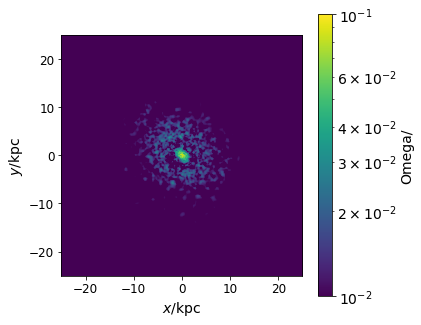

In [46]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
pynbody.plot.sph.image(main.s, qty='Omega', log=True, vmin=1e-2, vmax=1e-1, width=50, axes=ax, show_cbar=True, weight=False)
plt.tick_params(labelsize=12)
plt.tight_layout()
# plt.savefig('tidal_strength_final_withoutPM.pdf')